# TensorFlow Core Learning Algorithms

[Based On](https://colab.research.google.com/drive/15Cyy2H7nT40sGR7TBN5wBvgTd57mVKay#forceEdit=true&sandboxMode=true&scrollTo=Edndbw4sU5Wd)


Four fundemental machine learning algorithms:
* Linear Regression
* Classification
* Clustering
* Hidden Markov Models

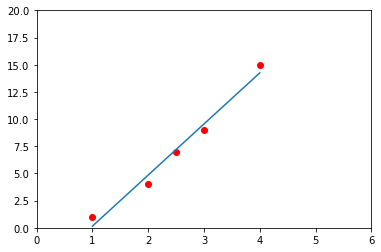

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# titanic training and testing data
dftrain = pd.read_csv('data/titanic_train.csv')
dfeval = pd.read_csv('data/titanic_eval.csv')

# pop removes specific data column and stores it in variable
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

### Explore data with build in functions

head() shows first 5 items of dataframe.

describe() displays a more statistical analysis.

In [8]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [10]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [12]:
dftrain.shape # 627 entries, 9 features

(627, 9)

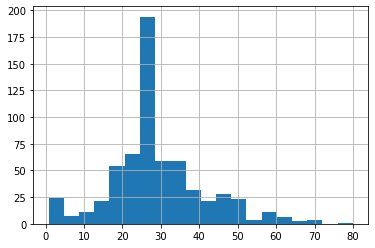

In [14]:
dftrain.age.hist(bins=20) # Most passengers are in their 20's or 30's

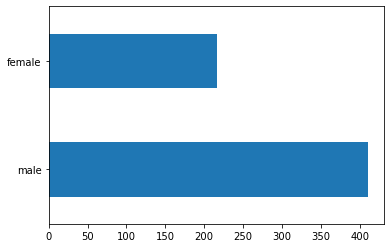

In [16]:
dftrain.sex.value_counts().plot(kind='barh') # Most passengers are male

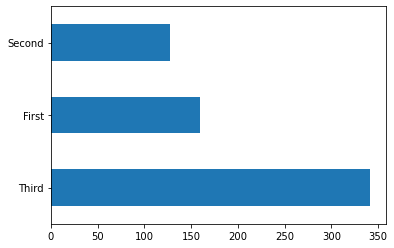

In [18]:
dftrain['class'].value_counts().plot(kind='barh') # most passengers are in third class

Text(0.5, 0, '% survive')

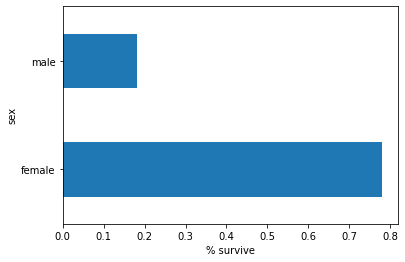

In [20]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
# females have much better chances to survive

## Testing vs. Training Data
Two datasets necessary for ML

**Training data:** feed to model to learn, so it develops. Much larger than testing data.

**Testing data:** evaluate the model, measure performance.

(?) Why seperate dataset to test?
(!) Make predictions with new data, otherwise model could simply memorize.

## Prepare Dataset: Feature Columns
Two different kind of information: **categorical** & **numeric*
Model needs categorical data to be numeric.
(e.g. male = 1, female = 2)

Tools to help in TensorFlow:

In [22]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # gets a list of all unique values from given feature column
  vocabulary = dftrain[feature_name].unique()  
  
  # maps string values to integer values
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# print(feature_columns)

## Training Process

### Feed input data to model

Data is feed in small batches of 32 entries, not entire dataset.
Bathces are feed multiple number of times, called **epochs**.
An **Epoch** is one stream of entire data.
Number of Epochs is how many times the model sees the same data.
Multipe Epochs to hope to get a better model.

**Input Function** defines how dataset is converted into batches at each epoch.

## Input Function
Needs ```tf.data.Dataset``` object.
Returns a function.

In [24]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    # create tf.data.Dataset object with data and its label
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  
    if shuffle:
      ds = ds.shuffle(1000)
    # split dataset into batches of 32 and repeat process for number of epochs
    ds = ds.batch(batch_size).repeat(num_epochs) 
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

## Model
linear estimator to utilize the linear regression algorithm


In [26]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/nz/48n490d10_dggw04m5r5z0d80000gp/T/tmp08g0746f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9aebaf0b90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [28]:
linear_est.train(train_input_fn) # train the model
result = linear_est.evaluate(eval_input_fn) # testing on testing data to get stats
clear_output()
print(result['accuracy']) # result is dictionary with model stats

{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.83529234, 'auc_precision_recall': 0.7896178, 'average_loss': 0.47772726, 'label/mean': 0.375, 'loss': 0.47116703, 'precision': 0.6442308, 'prediction/mean': 0.40767327, 'recall': 0.67676765, 'global_step': 200}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/nz/48n490d10_dggw04m5r5z0d80000gp/T/tmp08g0746f/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


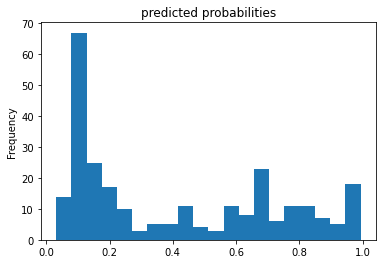

In [29]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')